Total Parameters: 8,344,864



/tmp/ipykernel_249633/1895025512.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cpu')  # Adjust map_location if

Checkpoint loaded from checkpoints/checkpoint.pth at epoch 300
Learning rate reset to 0.0001
Training...


Epoch 301 [Training]:   0%|                                                                                                                     | 0/705 [00:00<?, ?it/s]/tmp/ipykernel_249633/1895025512.py:670: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device == 'cuda')):
Epoch 301 [Validation]:   0%|                                                                                                                   | 0/177 [00:00<?, ?it/s]/tmp/ipykernel_249633/1895025512.py:708: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device == 'cuda')):


Epoch: 301, Train loss: 44.731506, Val loss: 84.656750, Train Dice: 20.892577, Val Dice: 0.429688, lr 1.000000e-04


Epoch: 302, Train loss: 31.021008, Val loss: 104.984913, Train Dice: 31.688922, Val Dice: 1.106476, lr 1.000000e-05


Epoch: 303, Train loss: 26.029499, Val loss: 31.644820, Train Dice: 36.052357, Val Dice: 30.893354, lr 1.000000e-05


Epoch: 304, Train loss: 24.841450, Val loss: 28.830248, Train Dice: 37.574007, Val Dice: 34.641405, lr 1.000000e-05


Epoch: 305, Train loss: 23.642315, Val loss: 28.874955, Train Dice: 38.053275, Val Dice: 32.006839, lr 1.000000e-05
Checkpoint saved at epoch 305 to checkpoints/checkpoint.pth
Model saved to /mnt/d/data/modified_unet_model.pth


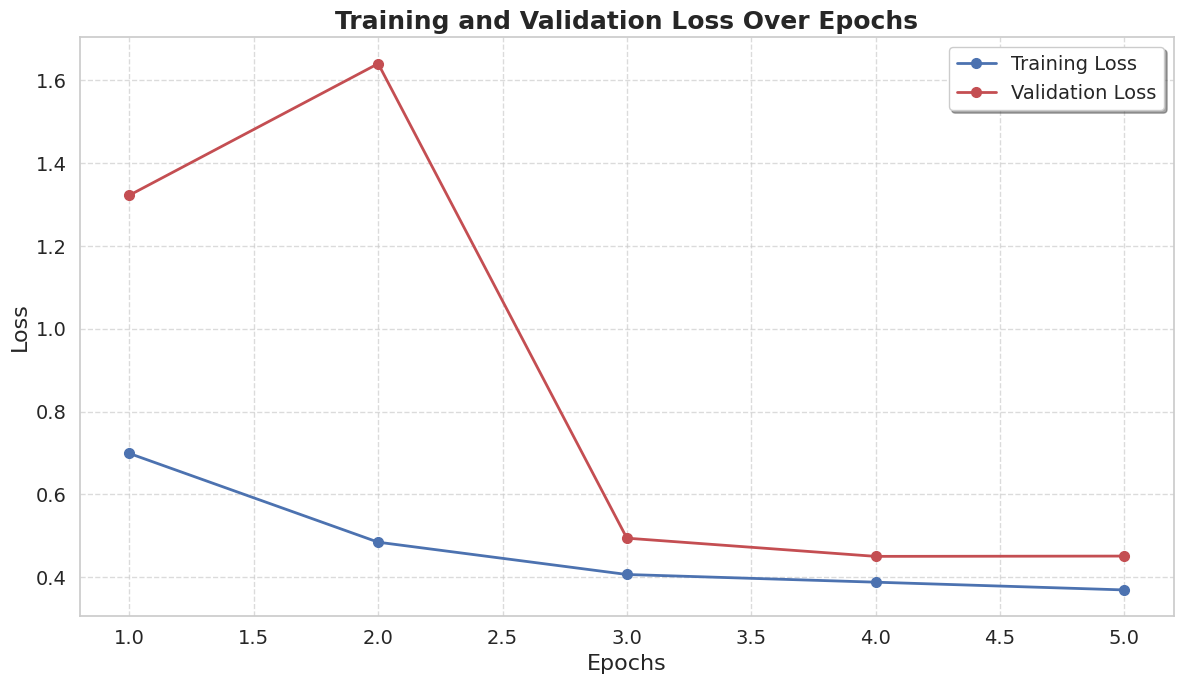

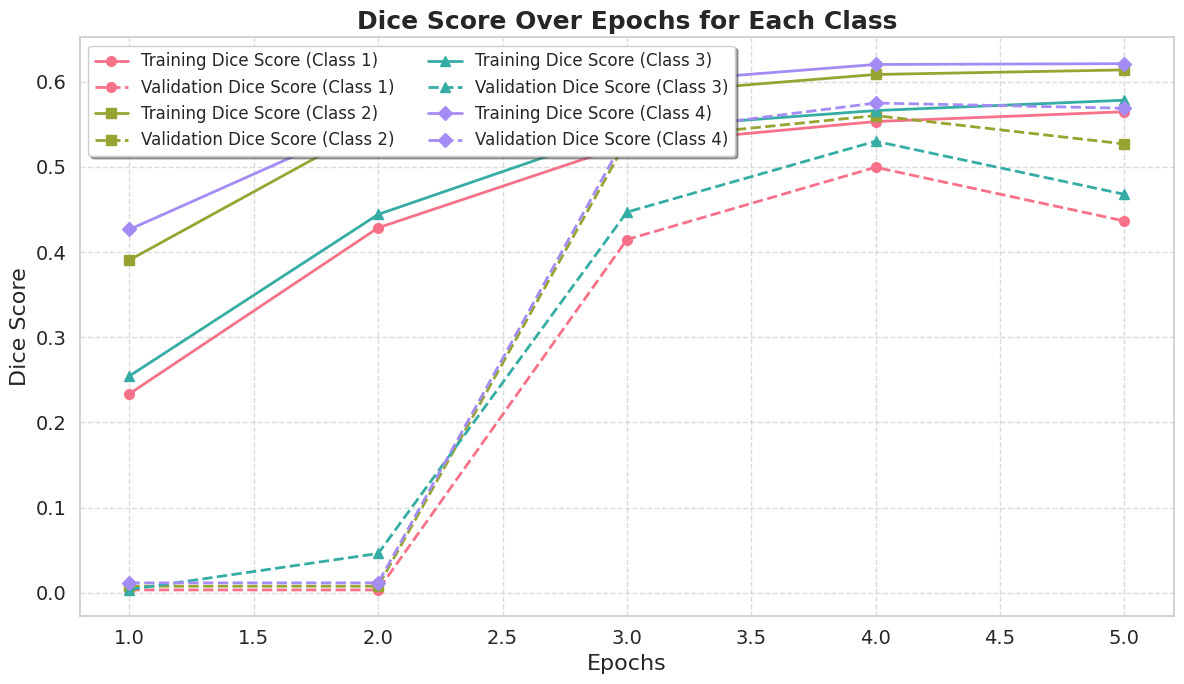

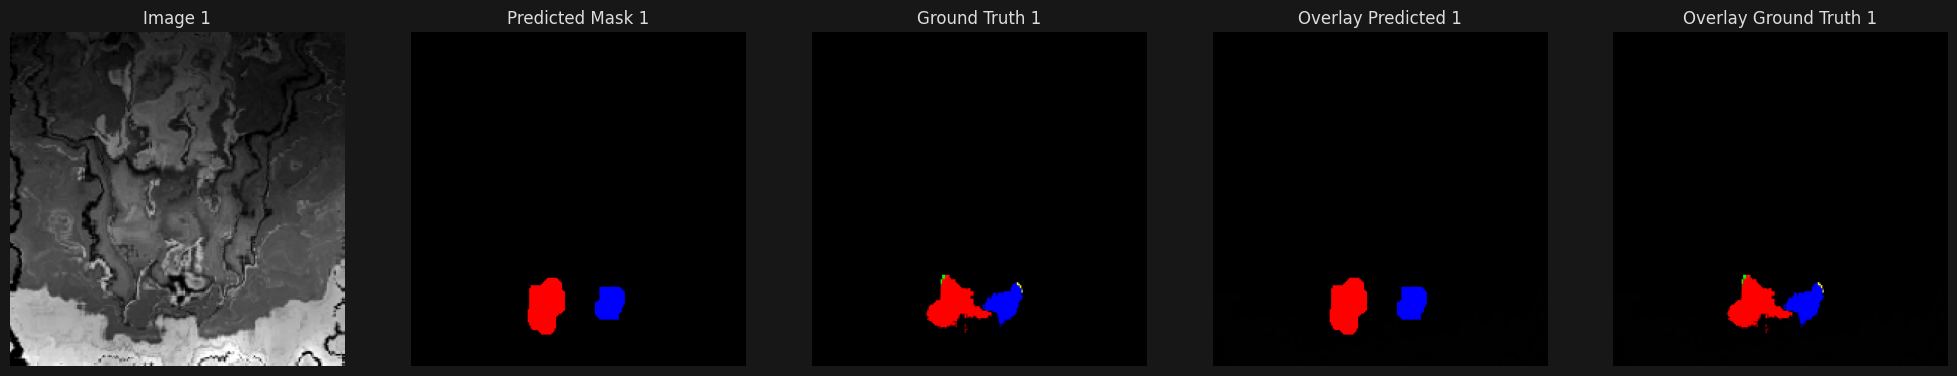

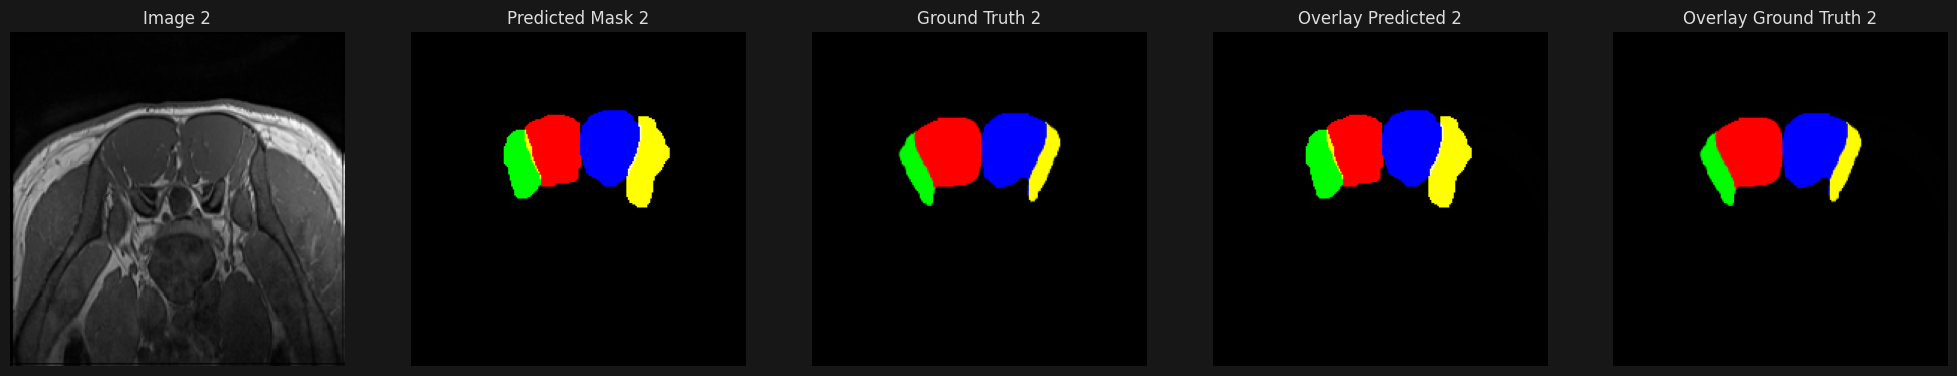

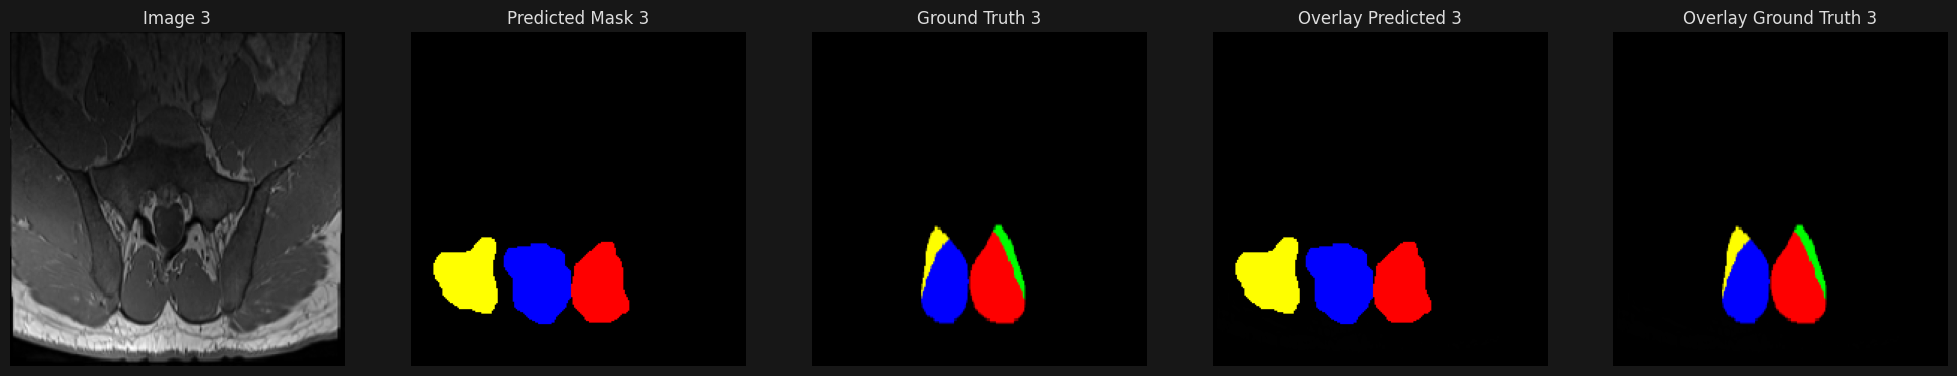

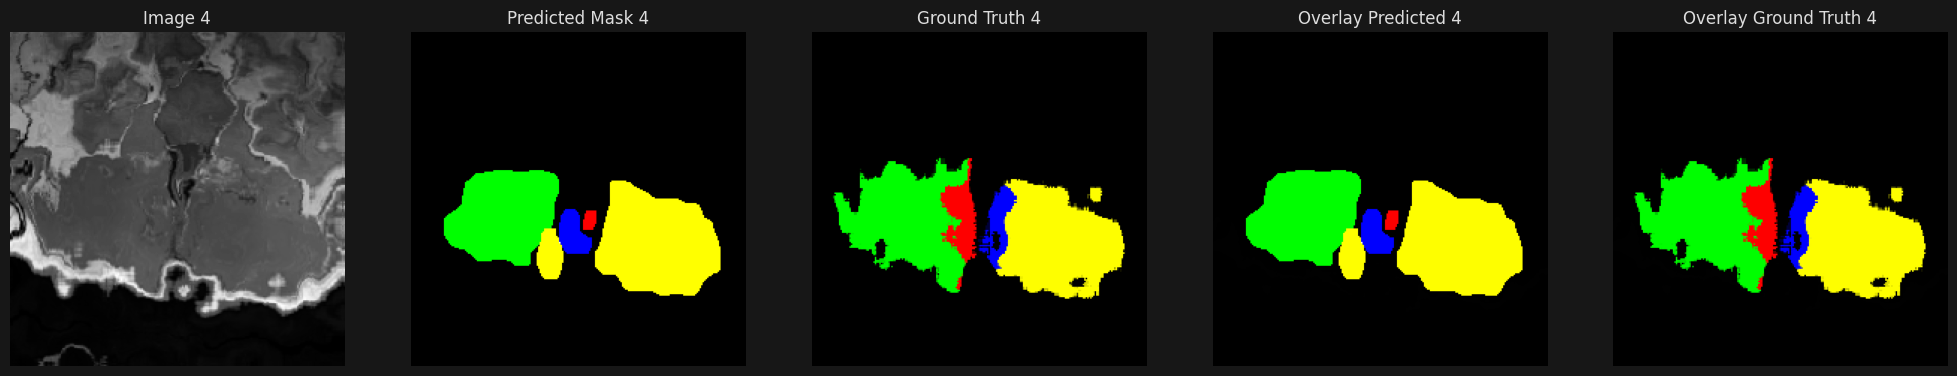

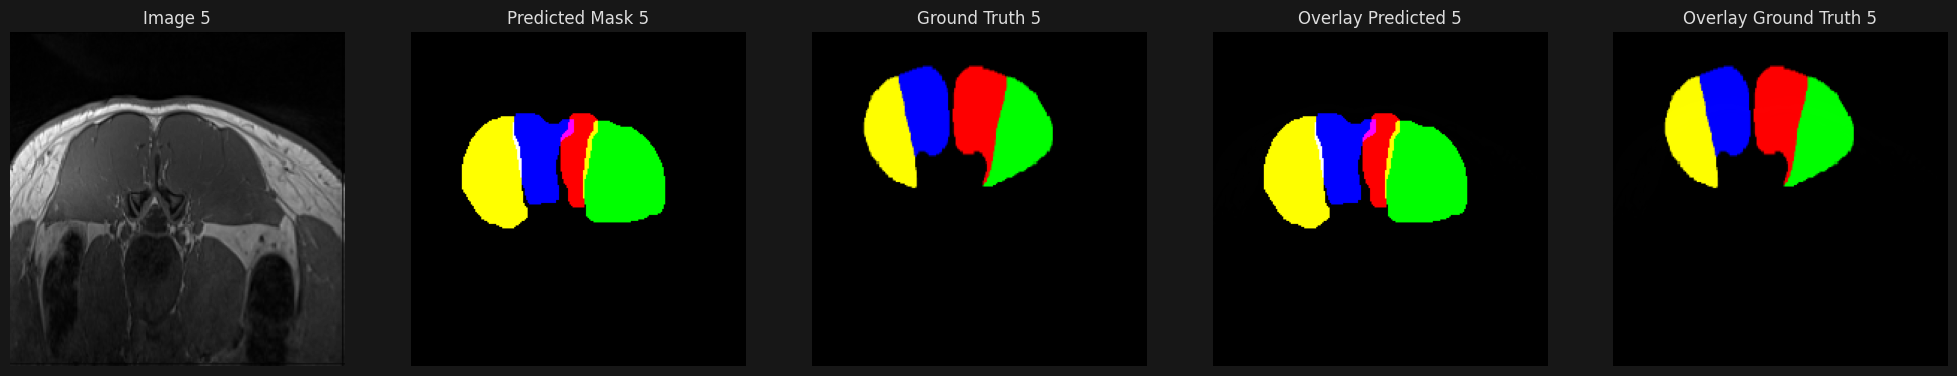

In [10]:
# ============================
# 1. Imports
# ============================

import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A

import cv2

# ============================
# 2. Data Augmentation Pipeline
# ============================

# Define the augmentation pipeline without ToTensorV2
augmentation_transform = A.Compose([
    # Geometric transforms applied to both image and mask
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
    A.ElasticTransform(alpha=120, sigma=6.0, p=0.5),
    A.GridDistortion(p=0.5),
    
    # Color transforms applied only to image
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=(0.0,), std=(1.0,)),  # Normalize images
    # ToTensorV2()  # Removed ToTensorV2
])

# ============================
# 3. Dataset Classes
# ============================

class PreprocessedHDF5Dataset(Dataset):
    def __init__(self, file_path, augmentation=None):
        """
        Args:
            file_path (str): Path to the HDF5 file.
            augmentation (albumentations.Compose): Augmentation pipeline.
        """
        self.file_path = file_path
        self.augmentation = augmentation

        # Open the HDF5 file once to retrieve keys
        with h5py.File(self.file_path, 'r') as f:
            # Assuming keys are named as 'image_0', 'mask_0', etc.
            self.image_keys = sorted([key for key in f.keys() if key.startswith('image_')])
            self.mask_keys = sorted([key for key in f.keys() if key.startswith('mask_')])

        assert len(self.image_keys) == len(self.mask_keys), "Number of images and masks should be equal."

    def __len__(self):
        return len(self.image_keys)

    def __getitem__(self, idx):
        with h5py.File(self.file_path, 'r') as f:
            image = f[self.image_keys[idx]][()]  # Shape: (1, H, W)
            mask = f[self.mask_keys[idx]][()]    # Shape: (4, H, W)

        # Convert image and mask to numpy arrays suitable for Albumentations
        image = image.squeeze(0)  # Shape: (H, W)
        mask = mask.transpose(1, 2, 0)  # Shape: (H, W, 4)

        # Apply augmentation
        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask)
            image = augmented['image']  # Shape: (H, W)
            mask = augmented['mask']    # Shape: (H, W, 4)

        # Transpose the mask back to (C, H, W)
        mask = mask.transpose(2, 0, 1)  # Shape: (4, H, W)
        # print(f"Mask shape after transpose: {mask.shape}")  # Debugging statement

        # Convert to PyTorch tensors manually
        image = torch.from_numpy(image).float().unsqueeze(0)  # Shape: (1, H, W)
        mask = torch.from_numpy(mask).float()  # Shape: (4, H, W)

        # Ensure mask has shape (4, H, W)
        if mask.ndimension() != 3 or mask.shape[0] != 4:
            raise ValueError(f"Expected mask shape (4, H, W), got {mask.shape}")

        # Convert masks to desired data type
        mask = mask.float()  # Use .long() if masks are categorical

        return image, mask  # Both are torch.Tensor objects

class SplitPreprocessedHDF5Dataset(Dataset):
    def __init__(self, file_path, indices, augmentation=None):
        """
        Args:
            file_path (str): Path to the HDF5 file.
            indices (list): List of indices for splitting the dataset.
            augmentation (albumentations.Compose): Augmentation pipeline.
        """
        self.file_path = file_path
        self.indices = indices
        self.augmentation = augmentation

        with h5py.File(self.file_path, 'r') as f:
            self.image_keys = sorted([key for key in f.keys() if key.startswith('image_')])
            self.mask_keys = sorted([key for key in f.keys() if key.startswith('mask_')])

        assert len(self.image_keys) == len(self.mask_keys), "Number of images and masks should be equal."

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        with h5py.File(self.file_path, 'r') as f:
            image = f[self.image_keys[real_idx]][()]  # Shape: (1, H, W)
            mask = f[self.mask_keys[real_idx]][()]    # Shape: (4, H, W)

        # Convert image and mask to numpy arrays suitable for Albumentations
        image = image.squeeze(0)  # Shape: (H, W)
        mask = mask.transpose(1, 2, 0)  # Shape: (H, W, 4)

        # Apply augmentation
        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask)
            image = augmented['image']  # Shape: (H, W)
            mask = augmented['mask']    # Shape: (H, W, 4)

        # Transpose the mask back to (C, H, W)
        mask = mask.transpose(2, 0, 1)  # Shape: (4, H, W)
        # print(f"Mask shape after transpose: {mask.shape}")  # Debugging statement

        # Convert to PyTorch tensors manually
        image = torch.from_numpy(image).float().unsqueeze(0)  # Shape: (1, H, W)
        mask = torch.from_numpy(mask).float()  # Shape: (4, H, W)

        # Ensure mask has shape (4, H, W)
        if mask.ndimension() != 3 or mask.shape[0] != 4:
            raise ValueError(f"Expected mask shape (4, H, W), got {mask.shape}")

        # Convert masks to desired data type
        mask = mask.float()  # Use .long() if masks are categorical

        return image, mask  # Both are torch.Tensor objects

# ============================
# 4. Visualization Functions
# ============================

def visualize_image_with_masks(image, masks, alpha=0.5, title="Image with Masks"):
    """
    Visualizes a grayscale image with overlaid masks.

    Parameters:
    - image (torch.Tensor or numpy.ndarray): Grayscale image tensor of shape (1, H, W) or (H, W).
    - masks (torch.Tensor or numpy.ndarray): Masks tensor of shape (4, H, W).
    - alpha (float): Transparency factor for mask overlays.
    - title (str): Title for the plot.
    """
    # Convert tensors to numpy arrays if necessary
    if isinstance(image, torch.Tensor):
        image = image.squeeze(0).cpu().numpy()  # Shape: (H, W)
    if isinstance(masks, torch.Tensor):
        masks = masks.cpu().numpy()  # Shape: (4, H, W)

    # Normalize the image to [0, 1] for visualization
    image_min, image_max = image.min(), image.max()
    if image_max - image_min > 0:
        image = (image - image_min) / (image_max - image_min)
    else:
        image = np.zeros_like(image)

    # Create an RGB version of the grayscale image
    image_rgb = np.stack([image, image, image], axis=-1)  # Shape: (H, W, 3)

    # Define distinct colors for each mask channel
    mask_colors = [
        (1, 0, 0),    # Red
        (0, 1, 0),    # Green
        (0, 0, 1),    # Blue
        (1, 1, 0)     # Yellow
    ]

    # Initialize an empty RGB mask
    mask_rgb = np.zeros_like(image_rgb)

    for i in range(masks.shape[0]):
        # Normalize each mask channel to [0, 1]
        mask = masks[i]
        mask_min, mask_max = mask.min(), mask.max()
        if mask_max - mask_min > 0:
            mask_normalized = (mask - mask_min) / (mask_max - mask_min)
        else:
            mask_normalized = np.zeros_like(mask)

        # Apply the color to the mask channel
        color = mask_colors[i % len(mask_colors)]
        for c in range(3):
            mask_rgb[..., c] += mask_normalized * color[c]

    # Ensure the mask RGB values are within [0, 1]
    mask_rgb = np.clip(mask_rgb, 0, 1)

    # Overlay the masks on the image using alpha blending
    overlay = (1 - alpha) * image_rgb + alpha * mask_rgb
    overlay = np.clip(overlay, 0, 1)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.imshow(overlay)
    plt.title(title)
    plt.axis('off')
    plt.show()

def validate_masks(masks):
    """
    Validates the uniqueness of values in each mask channel.

    Parameters:
    - masks (torch.Tensor or numpy.ndarray): Masks tensor of shape (4, H, W).
    """
    if isinstance(masks, torch.Tensor):
        masks = masks.numpy()
    for i in range(masks.shape[0]):
        unique_values = np.unique(masks[i])
        print(f"Mask Channel {i+1} Unique Values: {unique_values}")

def create_overlay(image, mask):
    """Create an overlay of the mask on the image."""
    image_rgb = np.repeat(image[..., np.newaxis], 3, axis=-1)  # Convert grayscale to RGB
    mask_rgb = np.zeros_like(image_rgb)
    for i in range(min(3, mask.shape[0])):
        mask_rgb[..., i] = mask[i]
    if mask.shape[0] > 3:
        fourth_mask = mask[3]
        yellow_overlay = np.stack((fourth_mask, fourth_mask, np.zeros_like(fourth_mask)), axis=-1)
        mask_rgb = np.maximum(mask_rgb, yellow_overlay)
    overlay = 0.6 * image_rgb + 0.4 * mask_rgb
    return overlay / overlay.max()

def display_test_samples(model, test_inputs, test_targets, device, num_images_to_display=None):
    """Display test samples with predictions and ground truth."""
    model.eval()
    with torch.no_grad():
        test_preds = torch.sigmoid(model(test_inputs.to(device)))

    # Threshold predictions to binary masks
    threshold = 0.5
    test_preds_binary = (test_preds > threshold).float()

    # Post-processing: Apply Gaussian smoothing and morphological operations
    kernel = np.ones((5, 5), np.uint8)
    larger_kernel = np.ones((7, 7), np.uint8)  # Larger kernel for smoothing
    for i in range(test_preds_binary.shape[0]):  # Iterate over batch size
        for j in range(test_preds_binary.shape[1]):  # Iterate over classes
            mask = test_preds_binary[i, j].cpu().numpy().astype(np.uint8)
            mask = cv2.GaussianBlur(mask, (7, 7), 0)  # Apply larger Gaussian smoothing
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, larger_kernel)  # Closing operation
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, larger_kernel)  # Opening operation
            test_preds_binary[i, j] = torch.tensor(mask, dtype=torch.float32, device=test_preds_binary.device)

    # Process the images and masks for visualization
    images = test_inputs.cpu().numpy()
    masks_pred = test_preds_binary.cpu().numpy()
    masks_target = test_targets.cpu().numpy()

    if num_images_to_display is not None:
        images = images[:num_images_to_display]
        masks_pred = masks_pred[:num_images_to_display]
        masks_target = masks_target[:num_images_to_display]

    num_images = images.shape[0]

    # Set the plot aesthetics
    plt.rcParams['figure.facecolor'] = '#171717'
    plt.rcParams['text.color'] = '#DDDDDD'

    # Display each image with its predicted and ground truth masks and overlays
    for i in range(num_images):
        fig, axes = plt.subplots(1, 5, figsize=(25, 5))

        # Display the input image
        ax = axes[0]
        ax.imshow(images[i][0], cmap='gray')
        ax.set_title(f'Image {i+1}')
        ax.axis('off')

        # Display the predicted mask
        mask_pred = masks_pred[i]
        mask_rgb = np.zeros((mask_pred.shape[1], mask_pred.shape[2], 3))
        for j in range(min(3, mask_pred.shape[0])):
            mask_rgb[..., j] = mask_pred[j]
        if mask_pred.shape[0] > 3:
            fourth_mask = mask_pred[3]
            yellow_overlay = np.stack((fourth_mask, fourth_mask, np.zeros_like(fourth_mask)), axis=-1)
            mask_rgb = np.maximum(mask_rgb, yellow_overlay)
        ax = axes[1]
        ax.imshow(mask_rgb)
        ax.set_title(f'Predicted Mask {i+1}')
        ax.axis('off')

        # Display the ground truth mask
        mask_target = masks_target[i]
        mask_rgb = np.zeros((mask_target.shape[1], mask_target.shape[2], 3))
        for j in range(min(3, mask_target.shape[0])):
            mask_rgb[..., j] = mask_target[j]
        if mask_target.shape[0] > 3:
            fourth_mask = mask_target[3]
            yellow_overlay = np.stack((fourth_mask, fourth_mask, np.zeros_like(fourth_mask)), axis=-1)
            mask_rgb = np.maximum(mask_rgb, yellow_overlay)
        ax = axes[2]
        ax.imshow(mask_rgb)
        ax.set_title(f'Ground Truth {i+1}')
        ax.axis('off')

        # Display the overlay of predicted mask on the original image
        overlay_pred = create_overlay(images[i][0], masks_pred[i])
        ax = axes[3]
        ax.imshow(overlay_pred)
        ax.set_title(f'Overlay Predicted {i+1}')
        ax.axis('off')

        # Display the overlay of ground truth mask on the original image
        overlay_target = create_overlay(images[i][0], masks_target[i])
        ax = axes[4]
        ax.imshow(overlay_target)
        ax.set_title(f'Overlay Ground Truth {i+1}')
        ax.axis('off')

        plt.show()

# ============================
# 5. Model Definition
# ============================

# Squeeze-and-Excitation Block
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        batch_size, channels, _, _ = x.size()
        # Global average pooling (squeeze)
        y = x.view(batch_size, channels, -1).mean(dim=2)
        # Fully connected layers
        y = self.fc1(y)
        y = F.relu(y)
        y = self.fc2(y)
        y = torch.sigmoid(y).view(batch_size, channels, 1, 1)
        # Scale input by learned weights
        return x * y.expand_as(x)

# Residual Encoder Block with SE Block
class ResidualEncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU(), use_se_block=True):
        super(ResidualEncoderBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.activation = activation
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se_block = SEBlock(out_channels) if use_se_block else nn.Identity()

        # Residual connection to match dimensions
        self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        identity = self.residual(x)  # Residual connection
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se_block(out)  # Apply SE block for channel-wise attention
        out += identity  # Add the residual connection
        out = self.activation(out)
        return out

# Residual Decoder Block with SE Block
class ResidualDecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU(), use_se_block=True):
        super(ResidualDecoderBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.activation = activation
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se_block = SEBlock(out_channels) if use_se_block else nn.Identity()

        # Residual connection to match dimensions
        self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        identity = self.residual(x)  # Residual connection
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se_block(out)  # Apply SE block for channel-wise attention
        out += identity  # Add the residual connection
        out = self.activation(out)
        return out

# Residual U-Net with SE Blocks
class ResidualUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=4, base_filters=32, use_se_block=True):
        super(ResidualUNet, self).__init__()

        self.downsample = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.enc_block_1 = ResidualEncoderBlock(in_channels, base_filters, use_se_block=use_se_block)
        self.enc_block_2 = ResidualEncoderBlock(base_filters, base_filters * 2, use_se_block=use_se_block)
        self.enc_block_3 = ResidualEncoderBlock(base_filters * 2, base_filters * 4, use_se_block=use_se_block)
        self.enc_block_4 = ResidualEncoderBlock(base_filters * 4, base_filters * 8, use_se_block=use_se_block)

        self.bottleneck = ResidualEncoderBlock(base_filters * 8, base_filters * 16, use_se_block=use_se_block)

        self.dec_block_4 = ResidualDecoderBlock(base_filters * 16 + base_filters * 8, base_filters * 8, use_se_block=use_se_block)
        self.dec_block_3 = ResidualDecoderBlock(base_filters * 8 + base_filters * 4, base_filters * 4, use_se_block=use_se_block)
        self.dec_block_2 = ResidualDecoderBlock(base_filters * 4 + base_filters * 2, base_filters * 2, use_se_block=use_se_block)
        self.dec_block_1 = ResidualDecoderBlock(base_filters * 2 + base_filters, base_filters, use_se_block=use_se_block)

        self.output_conv = nn.Conv2d(base_filters, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder path
        skip_1 = self.enc_block_1(x)
        x = self.downsample(skip_1)
        skip_2 = self.enc_block_2(x)
        x = self.downsample(skip_2)
        skip_3 = self.enc_block_3(x)
        x = self.downsample(skip_3)
        skip_4 = self.enc_block_4(x)
        x = self.downsample(skip_4)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder path with concatenation of skip connections
        x = self.upsample(x)
        x = torch.cat([x, skip_4], dim=1)  # Skip connection from enc_block_4
        x = self.dec_block_4(x)

        x = self.upsample(x)
        x = torch.cat([x, skip_3], dim=1)  # Skip connection from enc_block_3
        x = self.dec_block_3(x)

        x = self.upsample(x)
        x = torch.cat([x, skip_2], dim=1)  # Skip connection from enc_block_2
        x = self.dec_block_2(x)

        x = self.upsample(x)
        x = torch.cat([x, skip_1], dim=1)  # Skip connection from enc_block_1
        x = self.dec_block_1(x)

        # Output layer
        x = self.output_conv(x)
        return x

# ============================
# 6. Loss Functions
# ============================

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice

class CombinedLoss(nn.Module):
    def __init__(self, weight_dice=1.0, weight_bce=1.0):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.weight_dice = weight_dice
        self.weight_bce = weight_bce

    def forward(self, inputs, targets):
        dice = self.dice_loss(inputs, targets)
        bce = self.bce_loss(inputs, targets)
        return self.weight_dice * dice + self.weight_bce * bce

# ============================
# 7. Training Utilities
# ============================

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f'Total Parameters: {total_params:,}\n')

def save_checkpoint(model, optimizer, scheduler, epoch, checkpoint_dir='checkpoints', filename='checkpoint.pth'):
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, filename)
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint, checkpoint_path)
    print(f'Checkpoint saved at epoch {epoch} to {checkpoint_path}')

def load_checkpoint(model, optimizer, scheduler, checkpoint_dir='checkpoints', filename='aug_checkpoint.pth'):
    checkpoint_path = os.path.join(checkpoint_dir, filename)
    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location='cpu')  # Adjust map_location if needed
        model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        epoch = checkpoint['epoch']
        print(f'Checkpoint loaded from {checkpoint_path} at epoch {epoch}')
        return epoch
    else:
        print(f'No checkpoint found at {checkpoint_path}')
        return 0

def dice_coefficient(preds, targets, num_classes, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()

    # Apply morphological operations
    kernel = np.ones((5, 5), np.uint8)
    for i in range(preds.shape[0]):
        for j in range(num_classes):
            mask = preds[i, j].cpu().numpy().astype(np.uint8)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
            preds[i, j] = torch.tensor(mask, dtype=torch.float32, device=preds.device)

    dice_scores = []
    for i in range(num_classes):
        pred_i = preds[:, i, :, :]
        target_i = targets[:, i, :, :].float()

        intersection = (pred_i * target_i).sum(dim=(1, 2))
        union = pred_i.sum(dim=(1, 2)) + target_i.sum(dim=(1, 2))

        dice = (2. * intersection + 1e-6) / (union + 1e-6)
        dice_scores.append(dice.mean().item())

    return dice_scores

def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f'Model saved to {filepath}')

def plot_losses(train_losses, val_losses):
    sns.set(style="whitegrid")
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 7))
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss', markersize=7, linewidth=2)
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss', markersize=7, linewidth=2)

    plt.title('Training and Validation Loss Over Epochs', fontsize=18, fontweight='bold')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc='upper right', fontsize=14, frameon=True, shadow=True)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()

def plot_dice_scores(train_dice_scores, val_dice_scores, num_classes=4):
    sns.set(style="whitegrid")
    epochs = range(1, len(train_dice_scores) + 1)

    plt.figure(figsize=(12, 7))

    colors = sns.color_palette("husl", num_classes)
    markers = ['o', 's', '^', 'D', '*', 'x', '+']

    for class_idx in range(num_classes):
        train_class_scores = [epoch_scores[class_idx] for epoch_scores in train_dice_scores]
        val_class_scores = [epoch_scores[class_idx] for epoch_scores in val_dice_scores]

        plt.plot(epochs, train_class_scores, color=colors[class_idx],
                 marker=markers[class_idx % len(markers)], linewidth=2, markersize=7,
                 label=f'Training Dice Score (Class {class_idx + 1})')
        plt.plot(epochs, val_class_scores, color=colors[class_idx],
                 marker=markers[class_idx % len(markers)], linestyle='--', linewidth=2, markersize=7,
                 label=f'Validation Dice Score (Class {class_idx + 1})')

    plt.title('Dice Score Over Epochs for Each Class', fontsize=18, fontweight='bold')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Dice Score', fontsize=16)
    plt.legend(loc='upper left', fontsize=12, frameon=True, shadow=True, ncol=2)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()

# ============================
# 6. Training Loop
# ============================

def train_model(model, train_dataloader, val_dataloader, config, optimizer, scheduler, start_epoch=1, verbose=True):
    """
    Trains the model.

    Args:
        model (nn.Module): The segmentation model.
        train_dataloader (DataLoader): DataLoader for training data.
        val_dataloader (DataLoader): DataLoader for validation data.
        config (dict): Training configuration.
        optimizer (torch.optim.Optimizer): Optimizer.
        scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler.
        start_epoch (int): Epoch to start training from.
        verbose (bool): If True, prints training progress.

    Returns:
        Tuple: Lists of training and validation losses and dice scores per epoch.
    """
    device = config['device']
    n_epochs = config['n_epochs']
    batches_per_epoch = config['batches_per_epoch']
    num_classes = config['num_classes']
    checkpoint_every = config.get('checkpoint_every', 5)

    model.to(device)
    loss_fn = CombinedLoss(weight_dice=1.0, weight_bce=1.0)
    scaler = torch.amp.GradScaler(device=device) if device == 'cuda' else None

    train_epoch_losses = []
    val_epoch_losses = []
    train_epoch_dice_scores = []
    val_epoch_dice_scores = []

    print("Training...")
    for epoch in range(start_epoch, n_epochs + 1):
        model.train()
        train_epoch_loss = 0
        train_epoch_dice = [0.0] * num_classes
        train_loader = tqdm(train_dataloader, desc=f"Epoch {epoch} [Training]", leave=False)

        for train_batch_idx, (train_inputs, train_targets) in enumerate(train_loader, start=1):
            train_inputs = train_inputs.to(device)
            train_targets = train_targets.to(device)

            optimizer.zero_grad()

            # Use autocast with 'device_type' argument
            with torch.cuda.amp.autocast(enabled=(device == 'cuda')):
                train_preds = model(train_inputs)
                train_batch_loss = loss_fn(train_preds, train_targets)

            if scaler:
                scaler.scale(train_batch_loss).backward()
                # Apply gradient clipping to stabilize training
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                train_batch_loss.backward()
                # Apply gradient clipping to stabilize training
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            train_epoch_loss += train_batch_loss.item()
            train_batch_dice = dice_coefficient(train_preds, train_targets, num_classes)
            train_epoch_dice = [sum(x) for x in zip(train_epoch_dice, train_batch_dice)]

            if train_batch_idx >= batches_per_epoch:
                train_loader.close()
                break

        train_epoch_losses.append(train_epoch_loss / batches_per_epoch)
        train_epoch_dice_scores.append([x / batches_per_epoch for x in train_epoch_dice])

        # Validation step
        model.eval()
        val_epoch_loss = 0
        val_epoch_dice = [0.0] * num_classes
        val_loader = tqdm(val_dataloader, desc=f"Epoch {epoch} [Validation]", leave=False)
        with torch.no_grad():
            for val_batch_idx, (val_inputs, val_targets) in enumerate(val_loader, start=1):
                val_inputs = val_inputs.to(device)
                val_targets = val_targets.to(device)

                with torch.amp.autocast(device_type=device, enabled=(device == 'cuda')):
                    val_preds = model(val_inputs)
                    val_batch_loss = loss_fn(val_preds, val_targets)
                val_epoch_loss += val_batch_loss.item()

                val_batch_dice = dice_coefficient(val_preds, val_targets, num_classes)
                val_epoch_dice = [sum(x) for x in zip(val_epoch_dice, val_batch_dice)]

                if val_batch_idx >= batches_per_epoch:
                    val_loader.close()
                    break

        val_epoch_losses.append(val_epoch_loss / batches_per_epoch)
        val_epoch_dice_scores.append([x / batches_per_epoch for x in val_epoch_dice])

        # Step the scheduler based on validation loss
        scheduler.step(val_epoch_loss / batches_per_epoch)

        current_lr = optimizer.param_groups[0]['lr']
        if verbose:
            print(f"Epoch: {epoch}, Train loss: {train_epoch_loss:.6f}, Val loss: {val_epoch_loss:.6f}, "
                  f"Train Dice: {sum(train_epoch_dice) / num_classes:.6f}, "
                  f"Val Dice: {sum(val_epoch_dice) / num_classes:.6f}, "
                  f"lr {current_lr:.6e}")

        # Save checkpoint every 'checkpoint_every' epochs
        if epoch % checkpoint_every == 0:
            save_checkpoint(model, optimizer, scheduler, epoch)

    return train_epoch_losses, val_epoch_losses, train_epoch_dice_scores, val_epoch_dice_scores

# ============================
# 7. Main Execution Function
# ============================


# ============================
# Configuration
# ============================

train_config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs': 305,
    'batch_size': 32,
    'learning_rate': 1e-4,  # Reduced learning rate for stability
    'batches_per_epoch': 64,
    'checkpoint_every': 5,  # Saving more frequently
    'num_classes': 4,        # Number of mask channels/classes
    'data_path': '/mnt/d/data/data_preprocessed.hdf5',  # Update this to your dataset path
    'final_model_path': '/mnt/d/data/modified_unet_model.pth'  # Update this path as needed
}

# ============================
# Initialize the Model
# ============================

model = ResidualUNet(in_channels=1, out_channels=train_config['num_classes'], base_filters=32, use_se_block=True)
model.apply(init_weights)
count_parameters(model)
device = train_config['device']
model.to(device)

# ============================
# Initialize Optimizer and Scheduler
# ============================

optimizer = torch.optim.Adam(model.parameters(), lr=train_config['learning_rate'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3, threshold=1e-6, verbose=True
)

# ============================
# Load Checkpoint if Resuming
# ============================

resume_training = True  # Set to True if you want to resume from a checkpoint
if resume_training:
    start_epoch = load_checkpoint(
        model, optimizer, scheduler,
        checkpoint_dir='checkpoints',
        filename='aug_checkpoint.pth'
    )
    start_epoch += 1  # Start from the next epoch after the checkpoint

    # Manually reset the learning rate if needed
    for param_group in optimizer.param_groups:
        param_group['lr'] = train_config['learning_rate']
    print(f"Learning rate reset to {train_config['learning_rate']}")
else:
    start_epoch = 1

# ============================
# Initialize Datasets and Dataloaders
# ============================

data_path = train_config['data_path']

# Splitting the dataset into training and validation sets (80-20 split)
with h5py.File(data_path, 'r') as f:
    total_samples = len([key for key in f.keys() if key.startswith('image_')])

train_size = int(0.8 * total_samples)
val_size = total_samples - train_size

# Define a custom function to split indices
def get_indices(total, train_ratio=0.8):
    indices = list(range(total))
    np.random.shuffle(indices)
    train_count = int(train_ratio * total)
    return indices[:train_count], indices[train_count:]

train_indices, val_indices = get_indices(total_samples, train_ratio=0.8)

# Create training and validation datasets
train_dataset = SplitPreprocessedHDF5Dataset(file_path=data_path, indices=train_indices, augmentation=augmentation_transform)
val_dataset = SplitPreprocessedHDF5Dataset(file_path=data_path, indices=val_indices, augmentation=augmentation_transform)

# Dataloaders
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=train_config['batch_size'], 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True
)
val_dataloader = DataLoader(
    val_dataset, 
    batch_size=train_config['batch_size'], 
    shuffle=False, 
    num_workers=4, 
    pin_memory=True
)

# ============================
# Train the Model
# ============================

train_epoch_losses, val_epoch_losses, train_epoch_dice_scores, val_epoch_dice_scores = train_model(
    model, train_dataloader, val_dataloader, train_config,
    optimizer, scheduler, start_epoch, verbose=True
)

# ============================
# Save the Final Model
# ============================

final_model_path = train_config['final_model_path']
save_model(model, final_model_path)

# ============================
# Plot Losses and Dice Scores
# ============================

plot_losses(train_epoch_losses, val_epoch_losses)
plot_dice_scores(train_epoch_dice_scores, val_epoch_dice_scores, num_classes=train_config['num_classes'])

# ============================
# Display Test Samples
# ============================

# Get a batch from the validation dataloader
test_inputs, test_targets = next(iter(val_dataloader))

# Display test samples
display_test_samples(model, test_inputs, test_targets, device, num_images_to_display=5)


Total Parameters: 8,344,864



/home/riemann/miniconda3/envs/new_ml_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_4046/3592396558.py:572: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where

Checkpoint loaded from checkpoints/checkpoint.pth at epoch 455
Learning rate reset to 0.0001
Training...
Model saved to /mnt/d/data/modified_unet_model.pth


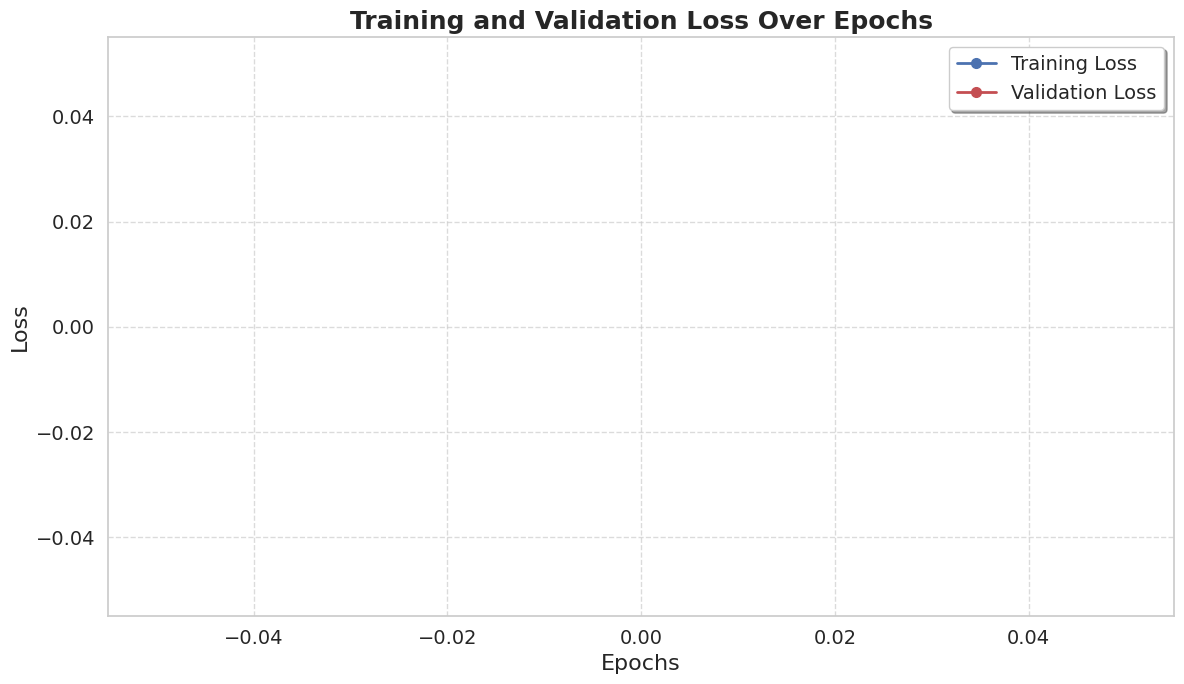

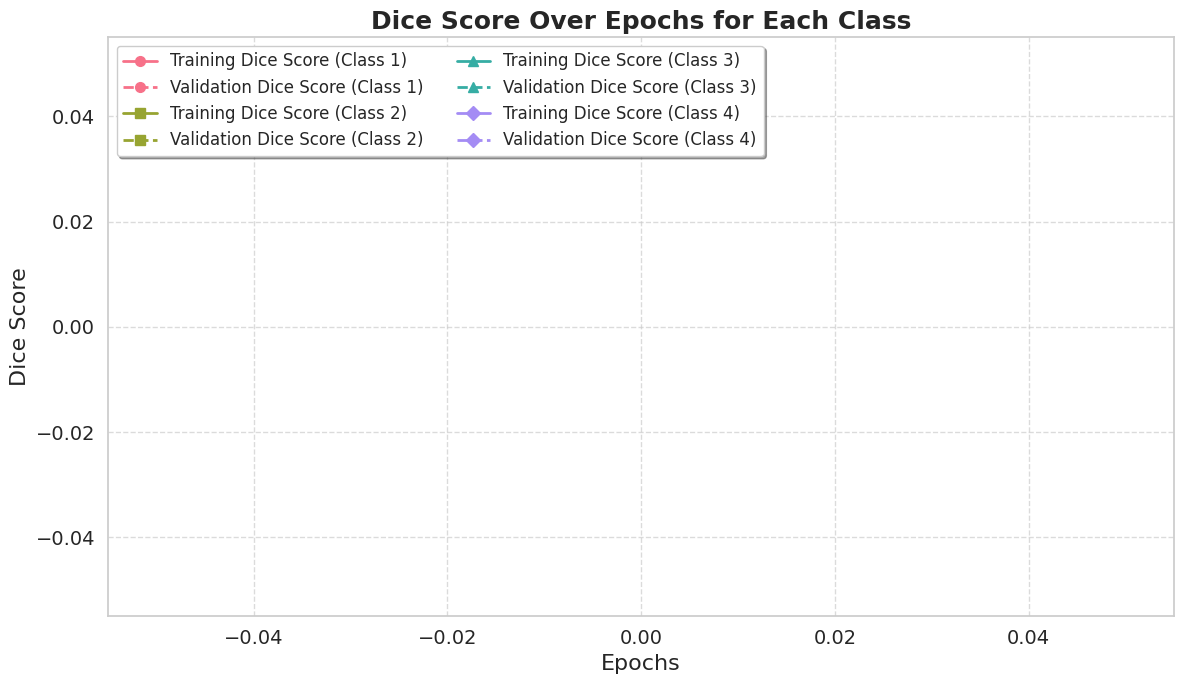

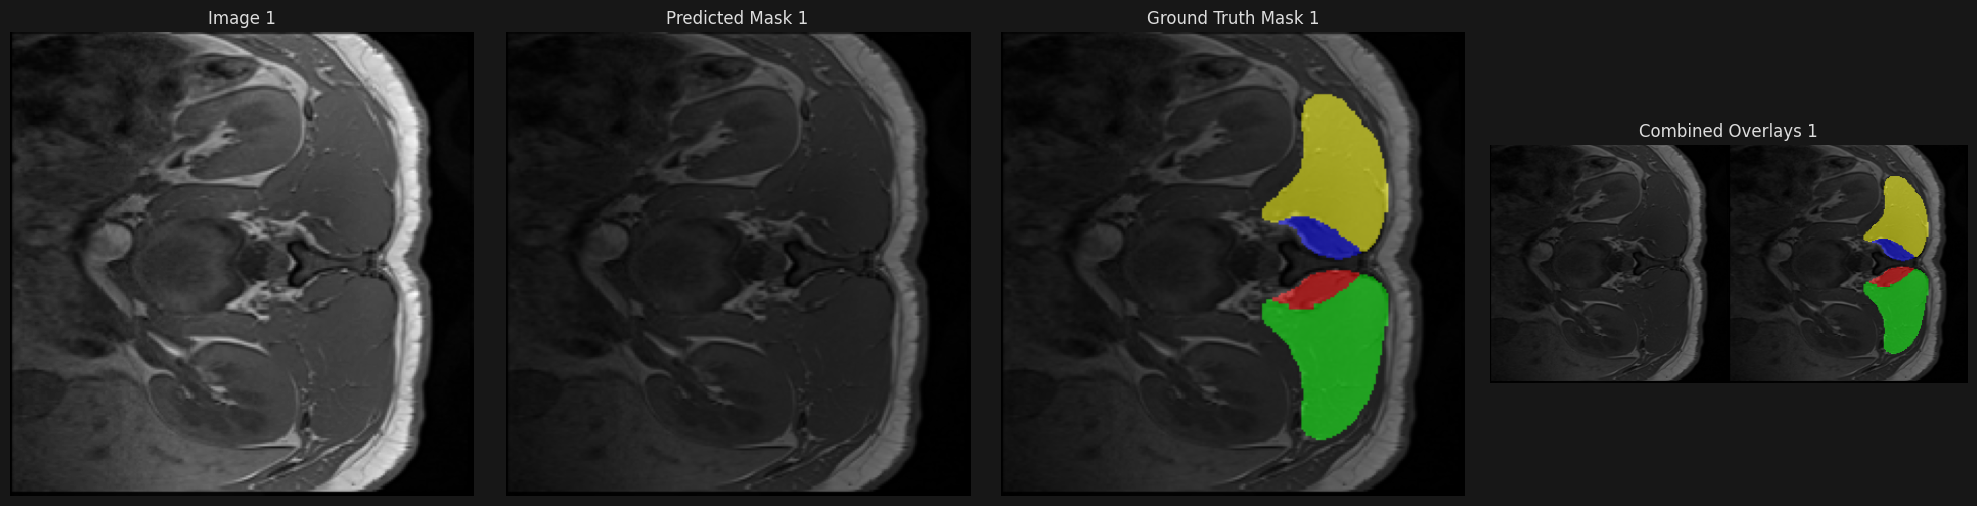

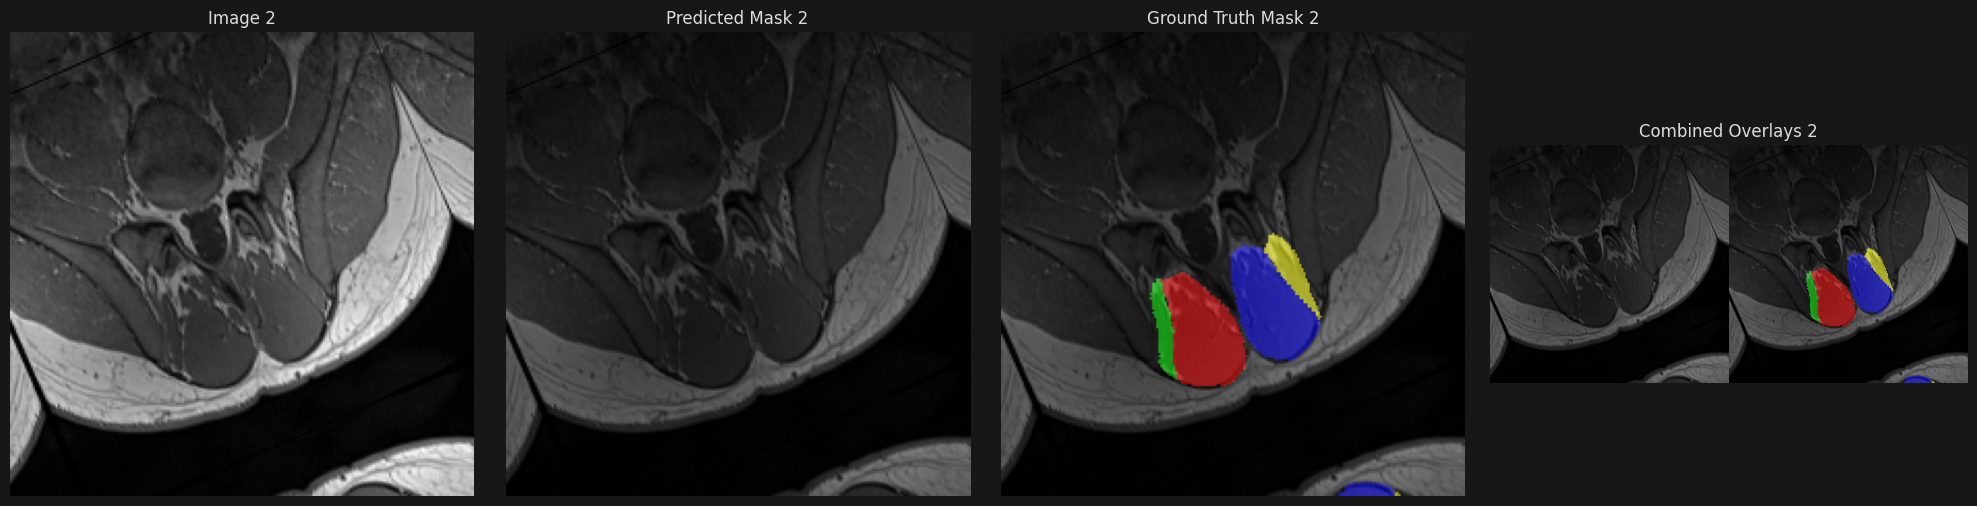

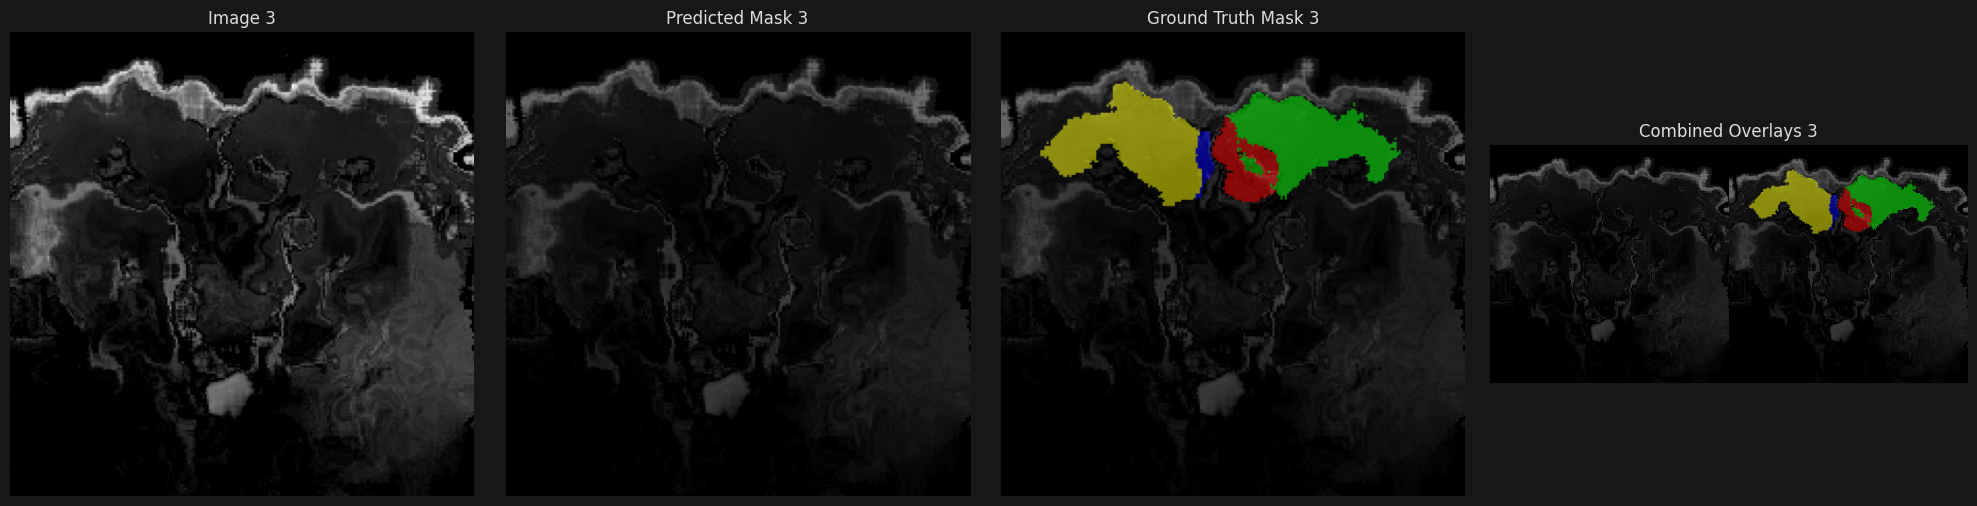

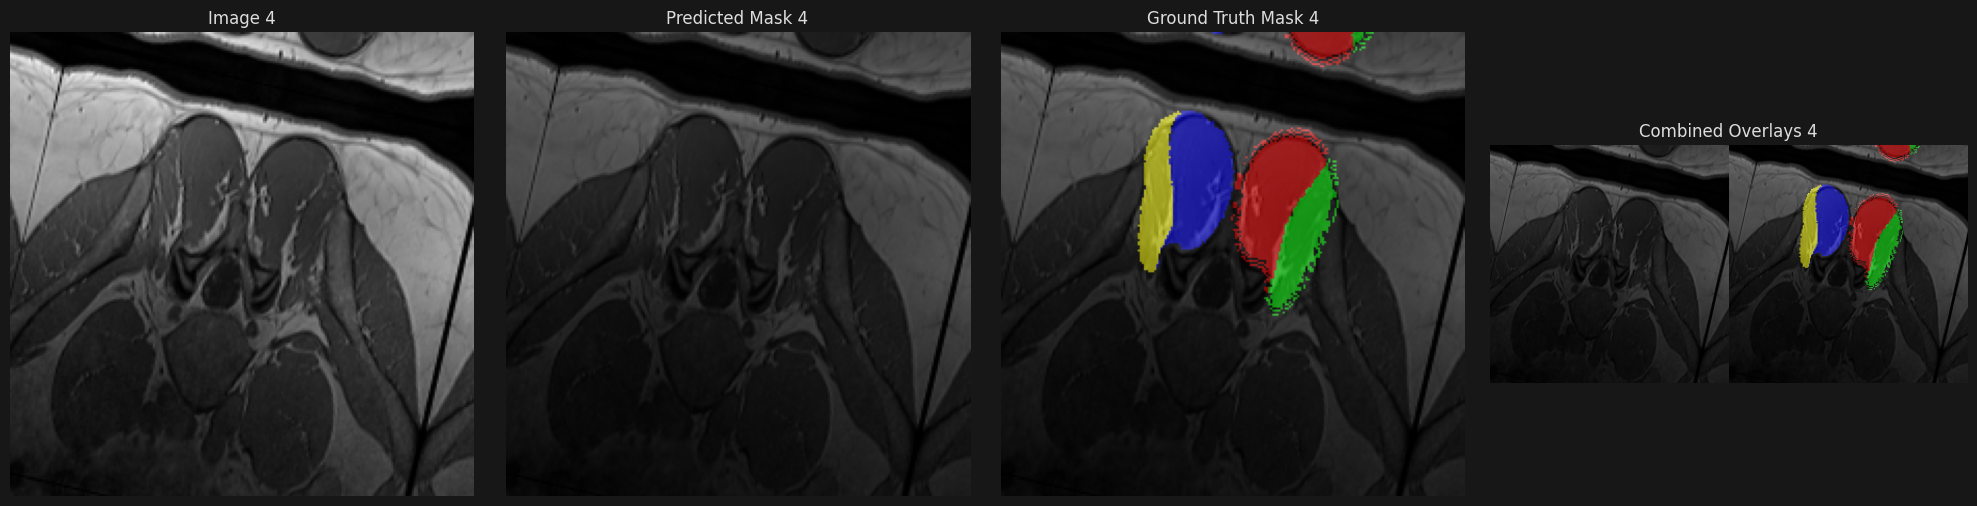

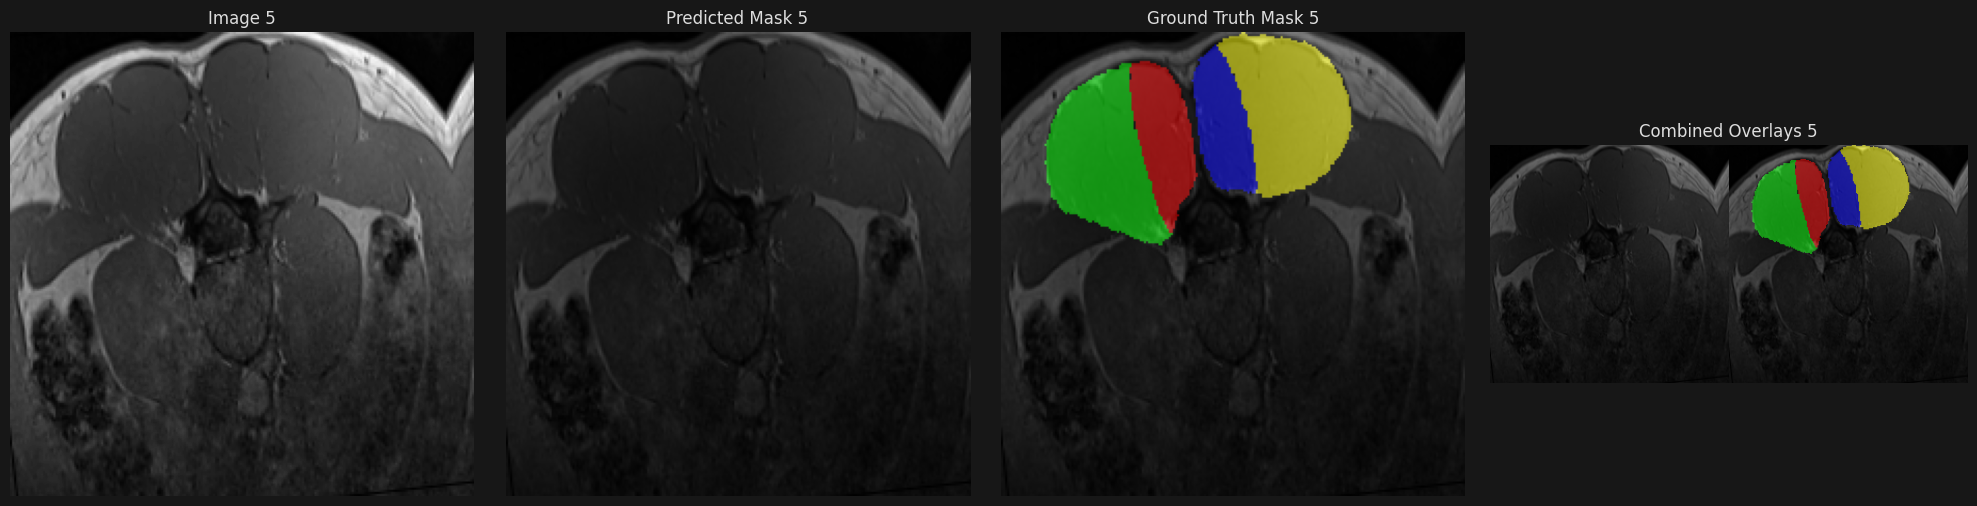

In [1]:
# ============================
# 1. Imports
# ============================

import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
# from albumentations.pytorch import ToTensorV2  # Removed ToTensorV2

import cv2

# ============================
# 2. Data Augmentation Pipeline
# ============================

# Define the augmentation pipeline without ToTensorV2
augmentation_transform = A.Compose([
    # Geometric transforms applied to both image and mask
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
    A.ElasticTransform(alpha=120, sigma=6.0, p=0.5),
    A.GridDistortion(p=0.5),
    
    # Color transforms applied only to image
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=(0.0,), std=(1.0,), max_pixel_value=255.0),  # Normalize images to [0, 1]
    # ToTensorV2()  # Removed ToTensorV2
])

# ============================
# 3. Dataset Classes
# ============================

class PreprocessedHDF5Dataset(Dataset):
    def __init__(self, file_path, augmentation=None):
        """
        Args:
            file_path (str): Path to the HDF5 file.
            augmentation (albumentations.Compose): Augmentation pipeline.
        """
        self.file_path = file_path
        self.augmentation = augmentation

        # Open the HDF5 file once to retrieve keys
        with h5py.File(self.file_path, 'r') as f:
            # Assuming keys are named as 'image_0', 'mask_0', etc.
            self.image_keys = sorted([key for key in f.keys() if key.startswith('image_')])
            self.mask_keys = sorted([key for key in f.keys() if key.startswith('mask_')])

        assert len(self.image_keys) == len(self.mask_keys), "Number of images and masks should be equal."

    def __len__(self):
        return len(self.image_keys)

    def __getitem__(self, idx):
        with h5py.File(self.file_path, 'r') as f:
            image = f[self.image_keys[idx]][()]  # Shape: (1, H, W)
            mask = f[self.mask_keys[idx]][()]    # Shape: (4, H, W)

        # Convert image and mask to numpy arrays suitable for Albumentations
        image = image.squeeze(0)  # Shape: (H, W)
        mask = mask.transpose(1, 2, 0)  # Shape: (H, W, 4)

        # Apply augmentation
        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask)
            image = augmented['image']  # Shape: (H, W)
            mask = augmented['mask']    # Shape: (H, W, 4)

        # Transpose the mask back to (C, H, W)
        mask = mask.transpose(2, 0, 1)  # Shape: (4, H, W)
        # print(f"Mask shape after transpose: {mask.shape}")  # Debugging statement

        # Convert to PyTorch tensors manually
        image = torch.from_numpy(image).float().unsqueeze(0)  # Shape: (1, H, W)
        mask = torch.from_numpy(mask).float()  # Shape: (4, H, W)

        # Ensure mask has shape (4, H, W)
        if mask.ndimension() != 3 or mask.shape[0] != 4:
            raise ValueError(f"Expected mask shape (4, H, W), got {mask.shape}")

        # Convert masks to desired data type
        mask = mask.float()  # Use .long() if masks are categorical

        return image, mask  # Both are torch.Tensor objects

class SplitPreprocessedHDF5Dataset(Dataset):
    def __init__(self, file_path, indices, augmentation=None):
        """
        Args:
            file_path (str): Path to the HDF5 file.
            indices (list): List of indices for splitting the dataset.
            augmentation (albumentations.Compose): Augmentation pipeline.
        """
        self.file_path = file_path
        self.indices = indices
        self.augmentation = augmentation

        with h5py.File(self.file_path, 'r') as f:
            self.image_keys = sorted([key for key in f.keys() if key.startswith('image_')])
            self.mask_keys = sorted([key for key in f.keys() if key.startswith('mask_')])

        assert len(self.image_keys) == len(self.mask_keys), "Number of images and masks should be equal."

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        with h5py.File(self.file_path, 'r') as f:
            image = f[self.image_keys[real_idx]][()]  # Shape: (1, H, W)
            mask = f[self.mask_keys[real_idx]][()]    # Shape: (4, H, W)

        # Convert image and mask to numpy arrays suitable for Albumentations
        image = image.squeeze(0)  # Shape: (H, W)
        mask = mask.transpose(1, 2, 0)  # Shape: (H, W, 4)

        # Apply augmentation
        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask)
            image = augmented['image']  # Shape: (H, W)
            mask = augmented['mask']    # Shape: (H, W, 4)

        # Transpose the mask back to (C, H, W)
        mask = mask.transpose(2, 0, 1)  # Shape: (4, H, W)
        # print(f"Mask shape after transpose: {mask.shape}")  # Debugging statement

        # Convert to PyTorch tensors manually
        image = torch.from_numpy(image).float().unsqueeze(0)  # Shape: (1, H, W)
        mask = torch.from_numpy(mask).float()  # Shape: (4, H, W)

        # Ensure mask has shape (4, H, W)
        if mask.ndimension() != 3 or mask.shape[0] != 4:
            raise ValueError(f"Expected mask shape (4, H, W), got {mask.shape}")

        # Convert masks to desired data type
        mask = mask.float()  # Use .long() if masks are categorical

        return image, mask  # Both are torch.Tensor objects

# ============================
# 4. Visualization Functions
# ============================

def plot_losses(train_losses, val_losses):
    sns.set(style="whitegrid")
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 7))
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss', markersize=7, linewidth=2)
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss', markersize=7, linewidth=2)

    plt.title('Training and Validation Loss Over Epochs', fontsize=18, fontweight='bold')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc='upper right', fontsize=14, frameon=True, shadow=True)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()


def plot_dice_scores(train_dice_scores, val_dice_scores, num_classes=4):
    sns.set(style="whitegrid")
    epochs = range(1, len(train_dice_scores) + 1)

    plt.figure(figsize=(12, 7))

    colors = sns.color_palette("husl", num_classes)
    markers = ['o', 's', '^', 'D', '*', 'x', '+']

    for class_idx in range(num_classes):
        train_class_scores = [epoch_scores[class_idx] for epoch_scores in train_dice_scores]
        val_class_scores = [epoch_scores[class_idx] for epoch_scores in val_dice_scores]

        plt.plot(epochs, train_class_scores, color=colors[class_idx],
                 marker=markers[class_idx % len(markers)], linewidth=2, markersize=7,
                 label=f'Training Dice Score (Class {class_idx + 1})')
        plt.plot(epochs, val_class_scores, color=colors[class_idx],
                 marker=markers[class_idx % len(markers)], linestyle='--', linewidth=2, markersize=7,
                 label=f'Validation Dice Score (Class {class_idx + 1})')

    plt.title('Dice Score Over Epochs for Each Class', fontsize=18, fontweight='bold')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Dice Score', fontsize=16)
    plt.legend(loc='upper left', fontsize=12, frameon=True, shadow=True, ncol=2)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()


def create_overlay(image, mask, alpha=0.5):
    """
    Create an overlay of the mask on the image.

    Parameters:
    - image (numpy.ndarray): Grayscale image array of shape (H, W).
    - mask (numpy.ndarray): Mask array of shape (4, H, W).
    - alpha (float): Transparency factor for mask overlays.

    Returns:
    - overlay (numpy.ndarray): RGB image with masks overlayed.
    """
    # Normalize the image to [0, 1]
    image_min, image_max = image.min(), image.max()
    if image_max - image_min > 0:
        image_norm = (image - image_min) / (image_max - image_min)
    else:
        image_norm = np.zeros_like(image)

    # Convert grayscale image to RGB
    image_rgb = np.stack([image_norm]*3, axis=-1)  # Shape: (H, W, 3)

    # Define distinct colors for each mask channel (R, G, B, Yellow)
    mask_colors = [
        (1, 0, 0),    # Red
        (0, 1, 0),    # Green
        (0, 0, 1),    # Blue
        (1, 1, 0)     # Yellow
    ]

    # Initialize an empty RGB mask
    mask_rgb = np.zeros_like(image_rgb)

    for i in range(mask.shape[0]):
        # Binarize the mask (assuming binary masks)
        mask_binary = (mask[i] > 0.5).astype(float)  # Threshold can be adjusted

        # Assign color to the mask channel
        for c in range(3):
            mask_rgb[..., c] += mask_binary * mask_colors[i][c]

    # Ensure mask RGB values are within [0, 1]
    mask_rgb = np.clip(mask_rgb, 0, 1)

    # Create the overlay using alpha blending
    overlay = (1 - alpha) * image_rgb + alpha * mask_rgb
    overlay = np.clip(overlay, 0, 1)  # Ensure values are within [0, 1]

    return overlay


def visualize_image_with_masks(image, masks, alpha=0.5, title="Image with Masks"):
    """
    Visualizes a grayscale image with overlaid masks.

    Parameters:
    - image (torch.Tensor or numpy.ndarray): Grayscale image tensor of shape (1, H, W) or (H, W).
    - masks (torch.Tensor or numpy.ndarray): Masks tensor of shape (4, H, W).
    - alpha (float): Transparency factor for mask overlays.
    - title (str): Title for the plot.
    """
    # Convert tensors to numpy arrays if necessary
    if isinstance(image, torch.Tensor):
        image = image.squeeze(0).cpu().numpy()  # Shape: (H, W)
    if isinstance(masks, torch.Tensor):
        masks = masks.cpu().numpy()  # Shape: (4, H, W)

    # Create the overlay
    overlay = create_overlay(image, masks, alpha=alpha)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.imshow(overlay)
    plt.title(title)
    plt.axis('off')
    plt.show()


def validate_masks(masks):
    """
    Validates the uniqueness of values in each mask channel.

    Parameters:
    - masks (torch.Tensor or numpy.ndarray): Masks tensor of shape (4, H, W).
    """
    if isinstance(masks, torch.Tensor):
        masks = masks.numpy()
    for i in range(masks.shape[0]):
        unique_values = np.unique(masks[i])
        print(f"Mask Channel {i+1} Unique Values: {unique_values}")


def display_test_samples(model, test_inputs, test_targets, device, num_images_to_display=None):
    """
    Display test samples with predictions and ground truth.

    Parameters:
    - model (nn.Module): Trained segmentation model.
    - test_inputs (torch.Tensor): Batch of input images.
    - test_targets (torch.Tensor): Batch of ground truth masks.
    - device (str): Device to perform computations on ('cpu' or 'cuda').
    - num_images_to_display (int, optional): Number of images to display from the batch.
    """
    model.eval()
    with torch.no_grad():
        test_preds = torch.sigmoid(model(test_inputs.to(device)))

    # Threshold predictions to binary masks
    threshold = 0.5
    test_preds_binary = (test_preds > threshold).float()

    # Post-processing: Apply Gaussian smoothing and morphological operations
    kernel = np.ones((5, 5), np.uint8)
    larger_kernel = np.ones((7, 7), np.uint8)  # Larger kernel for smoothing
    for i in range(test_preds_binary.shape[0]):  # Iterate over batch size
        for j in range(test_preds_binary.shape[1]):  # Iterate over classes
            mask = test_preds_binary[i, j].cpu().numpy().astype(np.uint8)
            mask = cv2.GaussianBlur(mask, (7, 7), 0)  # Apply larger Gaussian smoothing
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, larger_kernel)  # Closing operation
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, larger_kernel)  # Opening operation
            test_preds_binary[i, j] = torch.tensor(mask, dtype=torch.float32, device=test_preds_binary.device)

    # Process the images and masks for visualization
    images = test_inputs.cpu().numpy()
    masks_pred = test_preds_binary.cpu().numpy()
    masks_target = test_targets.cpu().numpy()

    if num_images_to_display is not None:
        images = images[:num_images_to_display]
        masks_pred = masks_pred[:num_images_to_display]
        masks_target = masks_target[:num_images_to_display]

    num_images = images.shape[0]

    # Set the plot aesthetics
    plt.rcParams['figure.facecolor'] = '#171717'
    plt.rcParams['text.color'] = '#DDDDDD'

    # Display each image with its predicted and ground truth masks and overlays
    for i in range(num_images):
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))

        # Display the input image
        ax = axes[0]
        ax.imshow(images[i][0], cmap='gray')
        ax.set_title(f'Image {i+1}')
        ax.axis('off')

        # Display the predicted mask overlay
        ax = axes[1]
        overlay_pred = create_overlay(images[i][0], masks_pred[i], alpha=0.5)
        ax.imshow(overlay_pred)
        ax.set_title(f'Predicted Mask {i+1}')
        ax.axis('off')

        # Display the ground truth mask overlay
        ax = axes[2]
        overlay_target = create_overlay(images[i][0], masks_target[i], alpha=0.5)
        ax.imshow(overlay_target)
        ax.set_title(f'Ground Truth Mask {i+1}')
        ax.axis('off')

        # Display both overlays side by side for comparison
        ax = axes[3]
        combined_overlay = np.hstack([overlay_pred, overlay_target])
        ax.imshow(combined_overlay)
        ax.set_title(f'Combined Overlays {i+1}')
        ax.axis('off')

        plt.tight_layout()
        plt.show()

# ============================
# 4. Model Definition
# ============================

# Squeeze-and-Excitation Block
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        batch_size, channels, _, _ = x.size()
        # Global average pooling (squeeze)
        y = x.view(batch_size, channels, -1).mean(dim=2)
        # Fully connected layers
        y = self.fc1(y)
        y = F.relu(y)
        y = self.fc2(y)
        y = torch.sigmoid(y).view(batch_size, channels, 1, 1)
        # Scale input by learned weights
        return x * y.expand_as(x)

# Residual Encoder Block with SE Block
class ResidualEncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU(), use_se_block=True):
        super(ResidualEncoderBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.activation = activation
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se_block = SEBlock(out_channels) if use_se_block else nn.Identity()

        # Residual connection to match dimensions
        self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        identity = self.residual(x)  # Residual connection
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se_block(out)  # Apply SE block for channel-wise attention
        out += identity  # Add the residual connection
        out = self.activation(out)
        return out

# Residual Decoder Block with SE Block
class ResidualDecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU(), use_se_block=True):
        super(ResidualDecoderBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.activation = activation
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se_block = SEBlock(out_channels) if use_se_block else nn.Identity()

        # Residual connection to match dimensions
        self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        identity = self.residual(x)  # Residual connection
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se_block(out)  # Apply SE block for channel-wise attention
        out += identity  # Add the residual connection
        out = self.activation(out)
        return out

# Residual U-Net with SE Blocks
class ResidualUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=4, base_filters=32, use_se_block=True):
        super(ResidualUNet, self).__init__()

        self.downsample = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.enc_block_1 = ResidualEncoderBlock(in_channels, base_filters, use_se_block=use_se_block)
        self.enc_block_2 = ResidualEncoderBlock(base_filters, base_filters * 2, use_se_block=use_se_block)
        self.enc_block_3 = ResidualEncoderBlock(base_filters * 2, base_filters * 4, use_se_block=use_se_block)
        self.enc_block_4 = ResidualEncoderBlock(base_filters * 4, base_filters * 8, use_se_block=use_se_block)

        self.bottleneck = ResidualEncoderBlock(base_filters * 8, base_filters * 16, use_se_block=use_se_block)

        self.dec_block_4 = ResidualDecoderBlock(base_filters * 16 + base_filters * 8, base_filters * 8, use_se_block=use_se_block)
        self.dec_block_3 = ResidualDecoderBlock(base_filters * 8 + base_filters * 4, base_filters * 4, use_se_block=use_se_block)
        self.dec_block_2 = ResidualDecoderBlock(base_filters * 4 + base_filters * 2, base_filters * 2, use_se_block=use_se_block)
        self.dec_block_1 = ResidualDecoderBlock(base_filters * 2 + base_filters, base_filters, use_se_block=use_se_block)

        self.output_conv = nn.Conv2d(base_filters, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder path
        skip_1 = self.enc_block_1(x)
        x = self.downsample(skip_1)
        skip_2 = self.enc_block_2(x)
        x = self.downsample(skip_2)
        skip_3 = self.enc_block_3(x)
        x = self.downsample(skip_3)
        skip_4 = self.enc_block_4(x)
        x = self.downsample(skip_4)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder path with concatenation of skip connections
        x = self.upsample(x)
        x = torch.cat([x, skip_4], dim=1)  # Skip connection from enc_block_4
        x = self.dec_block_4(x)

        x = self.upsample(x)
        x = torch.cat([x, skip_3], dim=1)  # Skip connection from enc_block_3
        x = self.dec_block_3(x)

        x = self.upsample(x)
        x = torch.cat([x, skip_2], dim=1)  # Skip connection from enc_block_2
        x = self.dec_block_2(x)

        x = self.upsample(x)
        x = torch.cat([x, skip_1], dim=1)  # Skip connection from enc_block_1
        x = self.dec_block_1(x)

        # Output layer
        x = self.output_conv(x)
        return x

# ============================
# 5. Loss Functions
# ============================

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice

class CombinedLoss(nn.Module):
    def __init__(self, weight_dice=1.0, weight_bce=1.0):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.weight_dice = weight_dice
        self.weight_bce = weight_bce

    def forward(self, inputs, targets):
        dice = self.dice_loss(inputs, targets)
        bce = self.bce_loss(inputs, targets)
        return self.weight_dice * dice + self.weight_bce * bce

# ============================
# 6. Training Utilities
# ============================

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f'Total Parameters: {total_params:,}\n')

def save_checkpoint(model, optimizer, scheduler, epoch, checkpoint_dir='checkpoints', filename='checkpoint.pth'):
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, filename)
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint, checkpoint_path)
    print(f'Checkpoint saved at epoch {epoch} to {checkpoint_path}')

def load_checkpoint(model, optimizer, scheduler, checkpoint_dir='checkpoints', filename='checkpoint.pth'):
    checkpoint_path = os.path.join(checkpoint_dir, filename)
    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location='cpu')  # Adjust map_location if needed
        model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        epoch = checkpoint['epoch']
        print(f'Checkpoint loaded from {checkpoint_path} at epoch {epoch}')
        return epoch
    else:
        print(f'No checkpoint found at {checkpoint_path}')
        return 0

def dice_coefficient(preds, targets, num_classes, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()

    # Apply morphological operations
    kernel = np.ones((5, 5), np.uint8)
    for i in range(preds.shape[0]):
        for j in range(num_classes):
            mask = preds[i, j].cpu().numpy().astype(np.uint8)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
            preds[i, j] = torch.tensor(mask, dtype=torch.float32, device=preds.device)

    dice_scores = []
    for i in range(num_classes):
        pred_i = preds[:, i, :, :]
        target_i = targets[:, i, :, :].float()

        intersection = (pred_i * target_i).sum(dim=(1, 2))
        union = pred_i.sum(dim=(1, 2)) + target_i.sum(dim=(1, 2))

        dice = (2. * intersection + 1e-6) / (union + 1e-6)
        dice_scores.append(dice.mean().item())

    return dice_scores

def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f'Model saved to {filepath}')

# ============================
# 7. Training Loop
# ============================

def train_model(model, train_dataloader, val_dataloader, config, optimizer, scheduler, start_epoch=1, verbose=True):
    """
    Trains the model.

    Args:
        model (nn.Module): The segmentation model.
        train_dataloader (DataLoader): DataLoader for training data.
        val_dataloader (DataLoader): DataLoader for validation data.
        config (dict): Training configuration.
        optimizer (torch.optim.Optimizer): Optimizer.
        scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler.
        start_epoch (int): Epoch to start training from.
        verbose (bool): If True, prints training progress.

    Returns:
        Tuple: Lists of training and validation losses and dice scores per epoch.
    """
    device = config['device']
    n_epochs = config['n_epochs']
    batches_per_epoch = config['batches_per_epoch']
    num_classes = config['num_classes']
    checkpoint_every = config.get('checkpoint_every', 5)

    model.to(device)
    loss_fn = CombinedLoss(weight_dice=1.0, weight_bce=1.0)
    
    # Initialize GradScaler appropriately based on device
    if device == 'cuda':
        scaler = torch.amp.GradScaler()
    else:
        scaler = None

    train_epoch_losses = []
    val_epoch_losses = []
    train_epoch_dice_scores = []
    val_epoch_dice_scores = []

    print("Training...")
    for epoch in range(start_epoch, n_epochs + 1):
        model.train()
        train_epoch_loss = 0
        train_epoch_dice = [0.0] * num_classes
        train_loader = tqdm(train_dataloader, desc=f"Epoch {epoch} [Training]", leave=False)

        for train_batch_idx, (train_inputs, train_targets) in enumerate(train_loader, start=1):
            train_inputs = train_inputs.to(device)
            train_targets = train_targets.to(device)

            optimizer.zero_grad()

            # Use autocast from torch.amp with device_type
            with torch.amp.autocast(device_type=device, enabled=(device == 'cuda')):
                train_preds = model(train_inputs)
                train_batch_loss = loss_fn(train_preds, train_targets)

            if scaler:
                scaler.scale(train_batch_loss).backward()
                # Apply gradient clipping to stabilize training
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                train_batch_loss.backward()
                # Apply gradient clipping to stabilize training
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            train_epoch_loss += train_batch_loss.item()
            train_batch_dice = dice_coefficient(train_preds, train_targets, num_classes)
            train_epoch_dice = [sum(x) for x in zip(train_epoch_dice, train_batch_dice)]

            if train_batch_idx >= batches_per_epoch:
                train_loader.close()
                break

        train_epoch_losses.append(train_epoch_loss / batches_per_epoch)
        train_epoch_dice_scores.append([x / batches_per_epoch for x in train_epoch_dice])

        # Validation step
        model.eval()
        val_epoch_loss = 0
        val_epoch_dice = [0.0] * num_classes
        val_loader = tqdm(val_dataloader, desc=f"Epoch {epoch} [Validation]", leave=False)
        with torch.no_grad():
            for val_batch_idx, (val_inputs, val_targets) in enumerate(val_loader, start=1):
                val_inputs = val_inputs.to(device)
                val_targets = val_targets.to(device)

                with torch.amp.autocast(device_type=device, enabled=(device == 'cuda')):
                    val_preds = model(val_inputs)
                    val_batch_loss = loss_fn(val_preds, val_targets)
                val_epoch_loss += val_batch_loss.item()

                val_batch_dice = dice_coefficient(val_preds, val_targets, num_classes)
                val_epoch_dice = [sum(x) for x in zip(val_epoch_dice, val_batch_dice)]

                if val_batch_idx >= batches_per_epoch:
                    val_loader.close()
                    break

        val_epoch_losses.append(val_epoch_loss / batches_per_epoch)
        val_epoch_dice_scores.append([x / batches_per_epoch for x in val_epoch_dice])

        # Step the scheduler based on validation loss
        scheduler.step(val_epoch_loss / batches_per_epoch)

        current_lr = optimizer.param_groups[0]['lr']
        if verbose:
            print(f"Epoch: {epoch}, Train loss: {train_epoch_loss:.6f}, Val loss: {val_epoch_loss:.6f}, "
                  f"Train Dice: {sum(train_epoch_dice) / num_classes:.6f}, "
                  f"Val Dice: {sum(val_epoch_dice) / num_classes:.6f}, "
                  f"lr {current_lr:.6e}")

        # Save checkpoint every 'checkpoint_every' epochs
        if epoch % checkpoint_every == 0:
            save_checkpoint(model, optimizer, scheduler, epoch)

    return train_epoch_losses, val_epoch_losses, train_epoch_dice_scores, val_epoch_dice_scores

# ============================
# 8. Main Execution Function
# ============================

def main():
    # ============================
    # Configuration
    # ============================

    train_config = {
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'n_epochs': 300,
        'batch_size': 32,
        'learning_rate': 1e-4,  # Reduced learning rate for stability
        'batches_per_epoch': 64,
        'checkpoint_every': 5,  # Saving more frequently
        'num_classes': 4,        # Number of mask channels/classes
        'data_path': '/mnt/d/data/data_preprocessed.hdf5',  # Update this to your dataset path
        'final_model_path': '/mnt/d/data/modified_unet_model.pth'  # Update this path as needed
    }

    # ============================
    # Initialize the Model
    # ============================

    model = ResidualUNet(in_channels=1, out_channels=train_config['num_classes'], base_filters=32, use_se_block=True)
    model.apply(init_weights)
    count_parameters(model)
    device = train_config['device']
    model.to(device)

    # ============================
    # Initialize Optimizer and Scheduler
    # ============================

    optimizer = torch.optim.Adam(model.parameters(), lr=train_config['learning_rate'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=3, threshold=1e-6, verbose=True
    )

    # ============================
    # Load Checkpoint if Resuming
    # ============================

    resume_training = True  # Set to True if you want to resume from a checkpoint
    if resume_training:
        start_epoch = load_checkpoint(
            model, optimizer, scheduler,
            checkpoint_dir='checkpoints',
            filename='checkpoint.pth'
        )
        start_epoch += 1  # Start from the next epoch after the checkpoint

        # Manually reset the learning rate if needed
        for param_group in optimizer.param_groups:
            param_group['lr'] = train_config['learning_rate']
        print(f"Learning rate reset to {train_config['learning_rate']}")
    else:
        start_epoch = 1

    # ============================
    # Initialize Datasets and Dataloaders
    # ============================

    data_path = train_config['data_path']

    # Splitting the dataset into training and validation sets (80-20 split)
    with h5py.File(data_path, 'r') as f:
        total_samples = len([key for key in f.keys() if key.startswith('image_')])

    train_size = int(0.8 * total_samples)
    val_size = total_samples - train_size

    # Define a custom function to split indices
    def get_indices(total, train_ratio=0.8):
        indices = list(range(total))
        np.random.shuffle(indices)
        train_count = int(train_ratio * total)
        return indices[:train_count], indices[train_count:]

    train_indices, val_indices = get_indices(total_samples, train_ratio=0.8)

    # Create training and validation datasets
    train_dataset = SplitPreprocessedHDF5Dataset(file_path=data_path, indices=train_indices, augmentation=augmentation_transform)
    val_dataset = SplitPreprocessedHDF5Dataset(file_path=data_path, indices=val_indices, augmentation=augmentation_transform)

    # Dataloaders
    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=train_config['batch_size'], 
        shuffle=True, 
        num_workers=4, 
        pin_memory=True
    )
    val_dataloader = DataLoader(
        val_dataset, 
        batch_size=train_config['batch_size'], 
        shuffle=False, 
        num_workers=4, 
        pin_memory=True
    )

    # ============================
    # Train the Model
    # ============================

    train_epoch_losses, val_epoch_losses, train_epoch_dice_scores, val_epoch_dice_scores = train_model(
        model, train_dataloader, val_dataloader, train_config,
        optimizer, scheduler, start_epoch, verbose=True
    )

    # ============================
    # Save the Final Model
    # ============================

    final_model_path = train_config['final_model_path']
    save_model(model, final_model_path)

    # ============================
    # Plot Losses and Dice Scores
    # ============================

    plot_losses(train_epoch_losses, val_epoch_losses)
    plot_dice_scores(train_epoch_dice_scores, val_epoch_dice_scores, num_classes=train_config['num_classes'])

    # ============================
    # Display Test Samples
    # ============================

    # Get a batch from the validation dataloader
    test_inputs, test_targets = next(iter(val_dataloader))

    # Display test samples
    display_test_samples(model, test_inputs, test_targets, device, num_images_to_display=5)

# ============================
# 9. Run the Main Function
# ============================

if __name__ == "__main__":
    main()
